In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def collectData(env, version):
  BASE_DIR = "./.checkpoints"
  results_dir = f'{BASE_DIR}/{env}/{version}'
  
  data = []
  for folder in sorted(os.listdir(results_dir)):
    if 'result.json' in os.listdir(f'{results_dir}/{folder}'):
      data.append(json.load(open(f'{results_dir}/{folder}/result.json')))
      
  return data

In [15]:
def plotResults(env, version, stats=[]):
  def getAllFromDict(key, listOfDicts):
    return [d[key] for d in listOfDicts]

  SAMPLER_KEYS = [
    'episode_reward_max',
    'episode_reward_min',
    'episode_reward_mean'
    ]
  LEARNER_KEYS = [
    'mean_q',
    'mean_td_error'
  ]
  TIME_KEYS = [
    "time_this_iter_s",
  ]
  PERF_KEYS = [
    "cpu_util_percent",
    "ram_util_percent"
  ]
  
  history = []
  
  data = collectData(env,version)

  for epoch in data:
    epoch_data = {}
    
    sampler = epoch['sampler_results']
    learner = epoch['info']['learner']['default_policy']['learner_stats']
    perf = epoch['perf']
    
    if 'REWARD' in stats:
      for key in SAMPLER_KEYS:
        epoch_data[key] = sampler[key]
    if 'LEARNER' in stats:
      for key in LEARNER_KEYS:
        epoch_data[key] = learner[key]
    if 'TIME' in stats:
      for key in TIME_KEYS:
        epoch_data[key] = epoch[key]
    if 'PERF' in stats:
      for key in PERF_KEYS:
        epoch_data[key] = perf[key]
    
    history.append(epoch_data)
  
  
  #PLOTTING 
  
  fig, axs = plt.subplots(2,constrained_layout=True)
  
  if 'REWARD' in stats:
    
    for key in SAMPLER_KEYS:
      axs[0].plot(getAllFromDict(key, history), label=key)
    
    axs[0].legend(bbox_to_anchor=(1,1))
    axs[0].set(xlabel="Epoch", ylabel="Reward", title="Reward Stats")
  
  if 'LEARNER' in stats:
    for key in LEARNER_KEYS:
      axs[1].plot(getAllFromDict(key, history), label=key)
    
    axs[1].legend(bbox_to_anchor=(1,1))
    axs[1].set(xlabel="Epoch", ylabel="Value", title="Learner Stats")

  if 'TIME' in stats:
    for key in TIME_KEYS:
      axs[1].plot(getAllFromDict(key, history), label=key)
    axs[1].legend(bbox_to_anchor=(1,1))
    axs[1].set(xlabel="Epoch", ylabel="Value", title="Time Stats")
    
  if 'PERF' in stats:
    for key in PERF_KEYS:
      axs[1].plot(getAllFromDict(key, history), label=key)
    axs[1].legend(bbox_to_anchor=(1,1))
    axs[1].set(xlabel="Epoch", ylabel="Value", title="Performance Stats")
    
  fig.suptitle(f'{env} - {version}')
  plt.show()



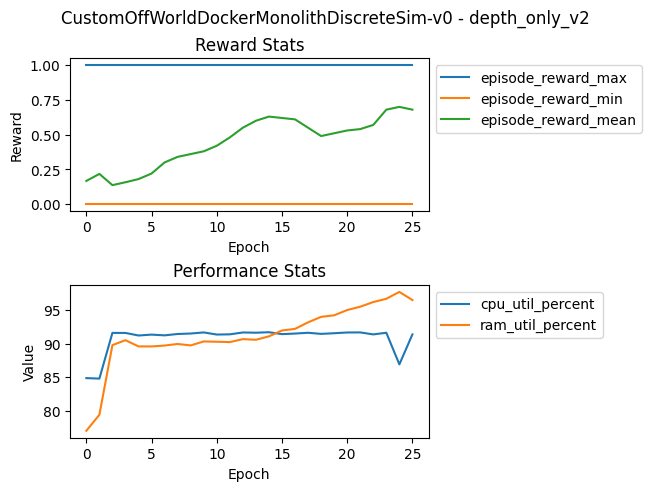

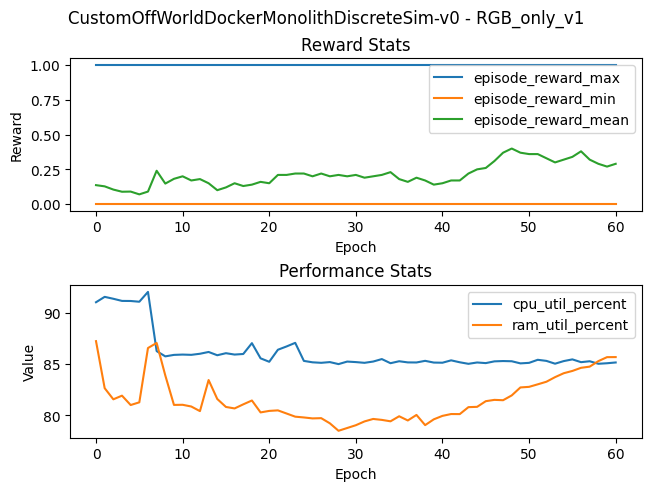

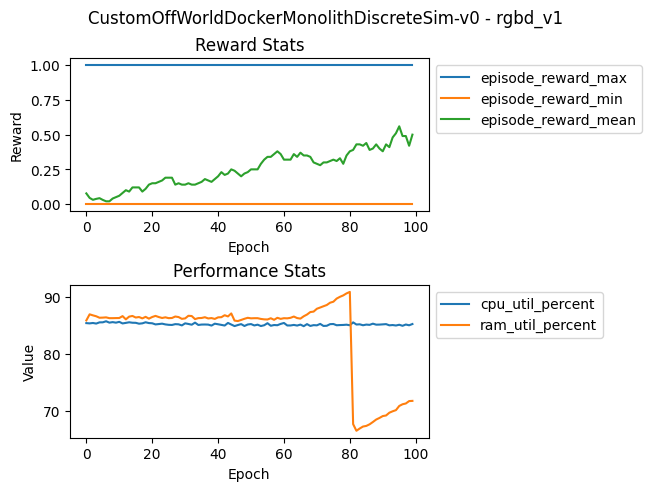

In [16]:
ENV = 'CustomOffWorldDockerMonolithDiscreteSim-v0'
VERSIONS = ['depth_only_v2','RGB_only_v1', 'rgbd_v1']
for version in VERSIONS:
    plotResults(ENV, version,['REWARD','PERF'])